# Title

Here's a [question from the Reddit statistics forum](https://www.reddit.com/r/AskStatistics/comments/1ddgpqr/comment/l860puz/?context=3).

> 

Hey,

I am currently trying to calculate some independent t-tests for my thesis and could use some help testing the assumption of the data being normally distributed.

My initial plan was to check the distribution visually and run a Shapiro-wilk test (I am using spss if that makes a difference).

So far so good, however the results don’t show a clear picture (to me) and I am not experienced enough to know what to make of it.

After visual inspection I would have judged most of my data to not be normally distributed. I have attached some examples. However, for all of these examples pictured, the Shapiro-wilk test did not turn out significant. I was unsure whether that might be due to missing power (my sample sizes range from n= 16 to n = 36). Since I really am no expert and don’t really trust my judgment, I then used R to calculate qqplots with confidence intervals for those cases. That absolute majority of my data points lie within the confidence intervals, with very few exceptions directly on the boarder or outside (but very close) to it (e.g. one or two out of 30 data points lie outside but very close to the interval) So now I am thinking that my visual judgment might be of?

Just out of interest I calculated one t-test and one Whitney-Mann test for one of my research questions to compare the results. They went into the same direction, however they did differ a bit (p = .29 vs p = .14).

Now I really do not know how to proceed. I am grateful for any advice on how to go on and which test to choose 🙏


Intro

Update the link...

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataQnA/blob/main/nb/normality.ipynb).

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataQnA/raw/main/nb/utils.py')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate

In [2]:
# install the empiricaldist library, if necessary

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

## Answer

In [19]:
from scipy.stats import lognorm

def make_lognormal(m, s, loc=0):
    scale = np.exp(m)
    dist = lognorm(s=s, loc=loc, scale=scale)
    return dist

In [25]:
dist1 = make_lognormal(0.5, 0.5)
dist1.mean(), dist1.std()

(1.8682459574322225, 0.9956636544919288)

In [71]:
dist2 = make_lognormal(0.75, 0.5)
dist2.mean(), dist2.std()

(2.398875293967098, 1.2784574388398384)

In [88]:
np.random.seed(17)

n = 30
group1 = dist1.rvs(n)
group2 = dist2.rvs(n)

In [115]:
from scipy.stats import norm
from empiricaldist import Cdf

def plot_normal(data, low, high, **options):
    mean = np.mean(data)
    std = np.std(data)

    xs = np.linspace(low, high)
    ps = norm(mean, std).cdf(xs)

    plt.plot(xs, ps, color='gray', alpha=0.5)
    Cdf.from_seq(data).plot(**options)
    decorate(xlabel='x', ylabel='Density')

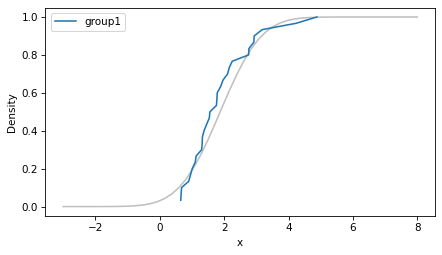

In [116]:
plot_normal(group1, -3, 8, label='group1')

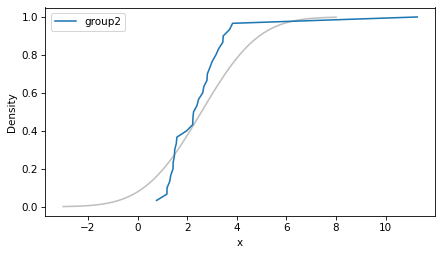

In [117]:
plot_normal(group2, -3, 8, label='group2')

In [118]:
actual_diff = group2.mean() - group1.mean()
actual_diff

0.6963910272326632

In [119]:
import statsmodels.stats.weightstats as smw

t_statistic, p_value, degrees_of_freedom = smw.ttest_ind(group1, group2)
p_value

0.07620445566354839

In [120]:
from scipy.stats import mannwhitneyu

u_statistic, p_value = mannwhitneyu(group1, group2)
p_value

0.03146563257725609

In [121]:
pooled = np.concatenate([group1, group2])
n, m = len(group1), len(group2)

In [122]:
def simulate_difference_mean():
    np.random.shuffle(pooled)
    shuffled1 = pooled[:n]
    shuffled2 = pooled[n:]
    diff = np.mean(shuffled1) - np.mean(shuffled2)
    return diff

In [123]:
sample = [simulate_difference_mean() for i in range(1001)]

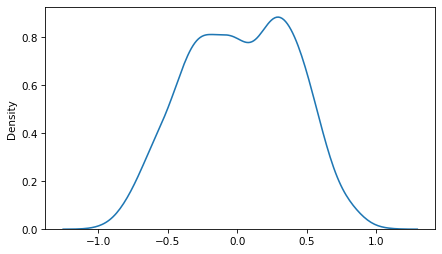

In [124]:
sns.kdeplot(sample)
decorate()

In [125]:
p_value = (np.abs(sample) > actual_diff).mean()
p_value

0.04695304695304695

## When is it a problem?

0.04934743223842417 0.09203630416696473


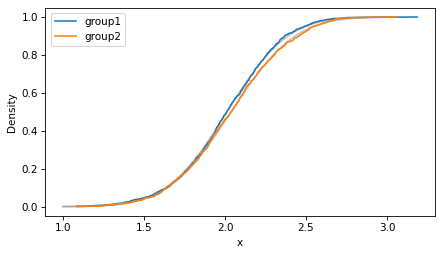

In [282]:
m1 = 2
m2 = 2.03
s = 0.3

np.random.seed(1)
group1 = norm(m1, s).rvs(1000)
group2 = norm(m2, s).rvs(1000)

plot_normal(group1, 1, 3, label='group1')
plot_normal(group2, 1, 3, label='group2')

_, p_value_ttest, _ = smw.ttest_ind(group1, group2)
_, p_value_mwu = mannwhitneyu(group1, group2)
print(p_value_ttest, p_value_mwu)

0.057697539354623684 0.0772719759293395


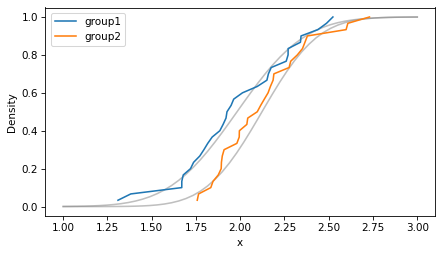

In [275]:
s = 0.3

np.random.seed(1)
group1 = norm(2, s).rvs(n)
group2 = norm(2.1, s).rvs(n)

plot_normal(group1, 1, 3, label='group1')
plot_normal(group2, 1, 3, label='group2')

_, p_value_ttest, _ = smw.ttest_ind(group1, group2)
_, p_value_mwu = mannwhitneyu(group1, group2)
print(p_value_ttest, p_value_mwu)

In [289]:
m1 = 0.5
m2 = 0.54
s = 0.1
seed = 1

np.random.seed(seed)
group1 = make_lognormal(0.5, s).rvs(n)
group2 = make_lognormal(0.54, s).rvs(n)

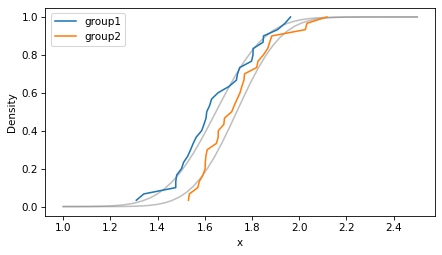

In [290]:
plot_normal(group1, 1, 2.5, label='group1')
plot_normal(group2, 1, 2.5, label='group2')

In [291]:
_, p_value_ttest, _ = smw.ttest_ind(group1, group2)
_, p_value_mwu = mannwhitneyu(group1, group2)
p_value_ttest, p_value_mwu

(0.03678318810141881, 0.045146208380795055)

In [315]:
def error_func(m2, s, seed=1, m1=0.5, target=0.05):
    np.random.seed(seed)
    group1 = make_lognormal(0.5, s).rvs(n)
    group2 = make_lognormal(m2, s).rvs(n)

    _, p_value_mwu = mannwhitneyu(group1, group2)
    return p_value_mwu - target

When `m2` is the same as `m1`, the p-value is large.

In [316]:
error_func(0.5, s)

0.6893988193114495

When `m2` is substantially larger than `m1`, the p-value is small.

In [317]:
s = 0.1
error_func(2, s, seed)

-0.04999999996980141

For a given value of `s`, we can use a root-finder to search for the value of `m2` that makes the p-value 0.5.

In [318]:
from scipy.optimize import brentq

s = 0.1
m2 = brentq(error_func, 0.5, 2, args=(s, seed))
m2, error_func(m2, s)

(0.5391725281757886, 0.00012023926200137314)

As we vary `s`, 

In [322]:
def run_loop(seed=1):
    res = []
    m1 = 0.5

    for s in np.linspace(0.01, 2):
        m2 = brentq(error_func, 0.5, 3, args=(s, seed))

        np.random.seed(seed)
        group1 = make_lognormal(m1, s).rvs(n)
        group2 = make_lognormal(m2, s).rvs(n)

        _, p_value_ttest, _ = smw.ttest_ind(group1, group2)
        _, p_value_mwu = mannwhitneyu(group1, group2)
        res.append((s, m2, p_value_mwu, p_value_ttest))

    columns = ['s', 'm2', 'p_value_mwu', 'p_value_ttest']
    return pd.DataFrame(res, columns=columns)

In [324]:
res_df = run_loop(2)

ValueError: f(a) and f(b) must have different signs

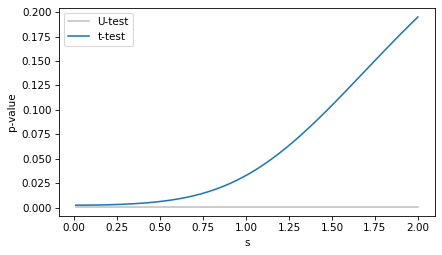

In [313]:
plt.plot(res_df['s'], res_df['p_value_mwu'], color='gray', alpha=0.5, label='U-test')
plt.plot(res_df['s'], res_df['p_value_ttest'], label='t-test')
decorate(xlabel='s')
decorate(ylabel='p-value')

In [205]:
def p_value_diff(group1, group2):
    _, p_value_ttest, _ = smw.ttest_ind(group1, group2)
    _, p_value_mwu = mannwhitneyu(group1, group2)
    
    return (p_value_ttest - p_value_mwu) / p_value_mwu

In [172]:
p_value_diff(group1, group2)

-0.9972148280841879

In [156]:
for s in np.linspace(0.001, 1):
    dist1 = make_lognormal(0.5, s)
    group1 = dist1.rvs(n)

    dist2 = make_lognormal(1, s)
    group2 = dist1.rvs(n)
    
    diff = p_value_diff(group1, group2)
    print(s, diff)

0.001 -0.012668751033228337
0.021387755102040818 -0.17952452136731245
0.041775510204081635 0.1780143598685222
0.062163265306122456 -0.05541294055828841
0.08255102040816327 -0.18267482686423442
0.10293877551020408 0.10329956655055539
0.12332653061224491 -0.22128462309678787
0.1437142857142857 -0.20621646432371163
0.16410204081632654 0.16713392120758508
0.18448979591836737 -0.20852061324216112
0.20487755102040817 -0.43329815105382946
0.225265306122449 0.23826574194950254
0.24565306122448982 -0.229401830903037
0.26604081632653065 -0.5990269867597802
0.2864285714285714 -0.013439972930953847
0.30681632653061225 -0.23306328061538492
0.3272040816326531 -0.2110727629930019
0.3475918367346939 -0.25296159033728255
0.36797959183673473 0.03795935630643725
0.3883673469387755 0.24609257028721435
0.40875510204081633 0.8407664581618356
0.42914285714285716 0.24303884846347082
0.449530612244898 -0.520205886203262
0.4699183673469388 -0.23839416778860678
0.49030612244897964 -0.4177127900970398
0.510693877

## Discussion

[*Data Q&A: Answering the real questions with Python*](https://allendowney.github.io/DataQnA/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)